# Свертка изображений

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output

## Загрузка изображения

Загрузим любое изображение из интернета. 

In [2]:
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2021-10-24 12:36:29--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: ‘butterfly.jpg.1’

butterfly.jpg.1     100%[===================>]  72.07K  --.-KB/s    in 0.05s   

2021-10-24 12:36:29 (1.48 MB/s) - ‘butterfly.jpg.1’ saved [73801/73801]



## Чтение изображения

In [3]:
!pip install Pillow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from PIL import Image
img = Image.open("butterfly.jpg")

In [5]:
print(img.format, img.size, img.mode)

JPEG (640, 427) RGB


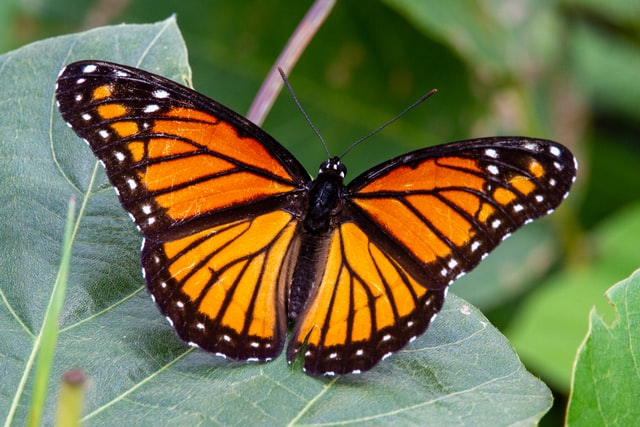

In [6]:
img

## Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

In [7]:
# получаем тензор
img_matrix = np.array(img)

#(высота, ширина, каналы)
img_matrix.shape

(427, 640, 3)

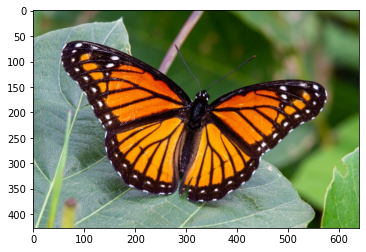

In [8]:
plt.imshow(img_matrix)
plt.show()

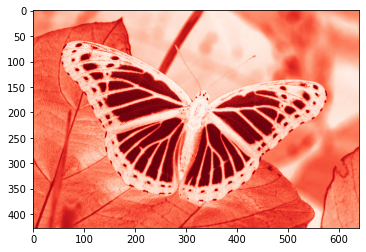

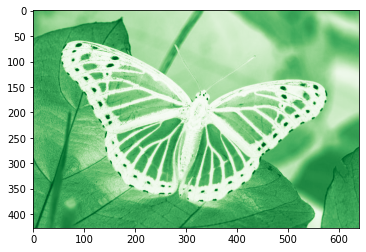

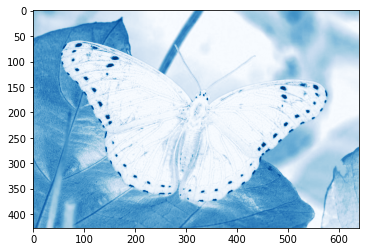

In [9]:
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

In [18]:
#### Классическое использование свертки:
import torch
# rgb: 3 канала -> 100 каналов 

pad = 3 // 2   # kernel_size // 2 -> H x W -> H x W ----> ....


# ks=3: 256x256 -> 252x252
# 256x256x3 -> conv (256x256x20)-> maxpool -> 128x128x20 -> conv -> maxpool -> 256/6

torch.nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3, padding=pad, stride=2)  # ks =(3, 3)

Conv2d(3, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [11]:
from torch.nn.functional import conv2d

In [ ]:
# Глянем документацию:
torch.nn.Conv2d??

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

![no_padding_no_strides.gif](no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

![no_padding_strides.gif](no_padding_strides.gif)

Шаг: 2

**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Half pading**
![same_padding_no_strides.gif](same_padding_no_strides.gif)

# Свертка изображения


Применим оператор Собеля для детектирования границ на изображении.

In [19]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в нужный формат для PyTorch

In [20]:
img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size()         #(число изображений, высота, ширина, число каналов)

/tmp/ipykernel_6196/615719835.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  img_tensor = torch.tensor([img_matrix], dtype=torch.float)


torch.Size([1, 427, 640, 3])

In [21]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size()         #(число изображений, число каналов, высота, ширина)

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [22]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [23]:
img_conv_hor = conv2d(img_tensor, kernel)

img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

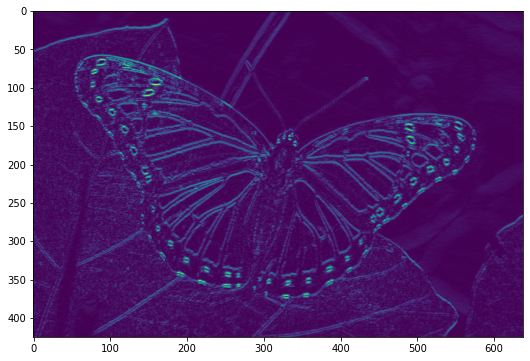

In [24]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Зададим оператор Собеля для детектирования вертикальных границ

In [25]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()                #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [26]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()          #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

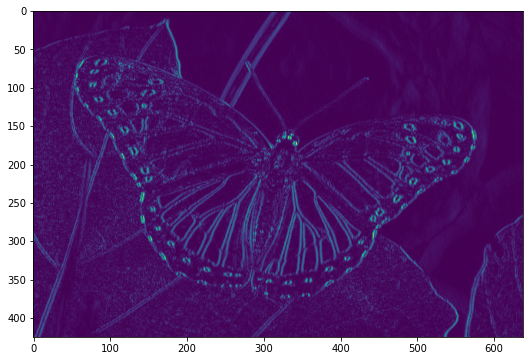

In [27]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

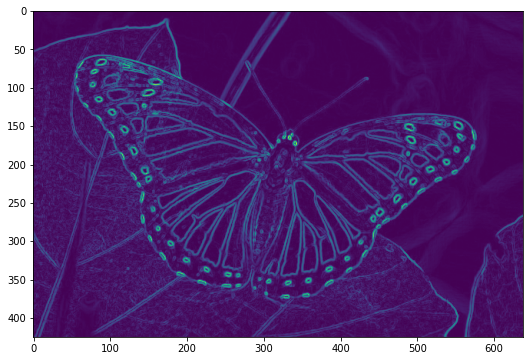

In [28]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

**Подсказка:** используйте `torch.rand()`.

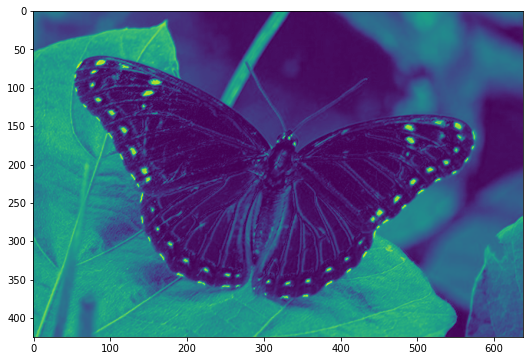

In [49]:
### your code here
kernel = torch.rand(1, 3, 3, 3)-0.5    # -0.5 чтобы было поразнообразние # ... 3,3 на 1 c_out, а на вход 3
### the end

# свертка изображения
img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

# Полносвязная нейронная сеть

Решим задачу классификации изображений полносвзяной нейронной сетью из прошлого семинара.

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Скачаем и подготовим данные для классификации.

In [50]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [51]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST('./mnist/', train=True, download=True, transform=transform)

# используем готовый класс от торча для загрузки данных для валидации
mnist_val = torchvision.datasets.MNIST('./mnist/', train=False, download=True, transform=transform)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...


/home/kirill/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [52]:
# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
                                               #num_workers=2, ...)

# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

Пример изображений

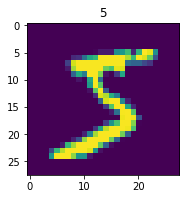

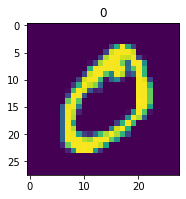

In [54]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
    plt.show()

Обучаем полносвязную нейронную сеть для классификации изображений

In [ ]:
# Более красивый и классические вариант, который мы пока не требуем:

'''myloss = nn.CrossEntropyLoss()

class MyNet():
    def __init__():
        myconv = nn.Conv2d(....)
        
        
    def forward():
        
        # apply layers
        
net = MyNet()
preds = net(train_data)
myloss(pred)
'''

In [68]:
model = nn.Sequential(
    nn.Flatten(),        # превращаем картинку 28х28 в вектор размером 784
    # (64, 3*h*w=784)
    nn.Linear(784, 128), # входной слой размером 784 нейронов с выходом в 128 нейронов
    # (64, 128)
    nn.ReLU(),           # функция активации релу
    nn.Linear(128, 10),  # функция активации релу
    # (64, 10) # числа
    # Это баг! -> # nn.Softmax(dim=-1)   # софтмакс для получения вероятностного распределения над метками класса
    # (64, 10) # вероятности (от 0 до 1 и суммируются в 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [66]:
# Укардено со стаковерфлоу

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [69]:
count_parameters(model)  # flatten дает очень много параметров

101770

In [83]:
def train(model, optimizer, train_dataloader, val_dataloader):
    epoch = 0
    for epoch in range(0,11):                            # всего у нас будет 10 эпох (10 раз подряд пройдемся по всем батчам из трейна)
        for x_train, y_train in tqdm(train_dataloader):  # берем батч из трейн лоадера
            
            # x_train: tensor(64, 3, h, w)    print(x_train.size())
            y_pred = model(x_train)                                  # делаем предсказания
            # y_pred: tensort(64, 10)
            loss = nn.functional.cross_entropy(y_pred, y_train)  # nn.CrossEntropyLoss()(y_pred, y_train)    # nllloss(log_softmax()                               # считаем лосс
            loss.backward()                                  # считаем градиенты обратным проходом
            optimizer.step() # for w: w -= 0.1 * w.grad()  # обн                                 овляем параметры сети
            optimizer.zero_grad()                                  # обнуляем посчитанные градиенты параметров

        # валидация
        mean_val_loss = [] # сюда будем складывать средний лосс по батчам
        val_accuracy = []
        with torch.no_grad(): # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):               # берем батч из вал лоадера
                y_pred = model(x_val)                               # делаем предсказания
                loss = nn.CrossEntropyLoss()(y_pred, y_val)         # считаем лосс
                mean_val_loss.append(loss.numpy())                  # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        # в приоритете -> #wandb.log('epoch':epoch, 'loss':loss)
        print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(mean_val_loss), accuracy=np.mean(val_accuracy)
        )) # выводим статистику
        
        
# Рекоммендуем:
#@torch.no_grad
#def validate()

In [61]:
train(model, optimizer, train_dataloader, val_dataloader)


Epoch: 0, loss: 1.8082562685012817, accuracy: 0.7319



Epoch: 1, loss: 1.6433476209640503, accuracy: 0.8767



Epoch: 2, loss: 1.5964558124542236, accuracy: 0.9008



Epoch: 3, loss: 1.5785982608795166, accuracy: 0.9085



Epoch: 4, loss: 1.56930673122406, accuracy: 0.9124



Epoch: 5, loss: 1.5628719329833984, accuracy: 0.9152



Epoch: 6, loss: 1.5579757690429688, accuracy: 0.9197



Epoch: 7, loss: 1.5536388158798218, accuracy: 0.9212



Epoch: 8, loss: 1.5509074926376343, accuracy: 0.9235



Epoch: 9, loss: 1.5479485988616943, accuracy: 0.9265



Epoch: 10, loss: 1.5462230443954468, accuracy: 0.9276


**Итог** Epoch: 10, loss: 1.5462230443954468, accuracy: 0.9276

# Сверточный слой

Добавим в нашу сеть сверточный слой. Обратите внимание на то, как изменится качество классификации.

In [63]:
model = nn.Sequential(
    # 1, h, w -> 10, 24, 24 -> 10, 24/4=6, 24/4=6 -> 
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим сверточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(4),                       # уменьшим картинку в 4 раза
    nn.Flatten(),                          # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128),                # входной слой размером 360 нейронов с выходом в 128 нейронов
    nn.ReLU(),                             # функция активации релу
    nn.Linear(128, 10),                    # еще линейный слой
    # Это баг! --> #nn.Softmax(dim=-1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [67]:
count_parameters(model)  # 1 conv layer

47758

In [65]:
train(model, optimizer, train_dataloader, val_dataloader)


Epoch: 0, loss: 0.2544848322868347, accuracy: 0.9229



Epoch: 1, loss: 0.15087531507015228, accuracy: 0.9552



Epoch: 2, loss: 0.10357525199651718, accuracy: 0.9709



Epoch: 3, loss: 0.08522047847509384, accuracy: 0.9749



Epoch: 4, loss: 0.07327134162187576, accuracy: 0.9779



Epoch: 5, loss: 0.07051902264356613, accuracy: 0.9792



Epoch: 6, loss: 0.05865262448787689, accuracy: 0.9818



Epoch: 7, loss: 0.05435403063893318, accuracy: 0.9825



Epoch: 8, loss: 0.050547268241643906, accuracy: 0.9837



Epoch: 9, loss: 0.04940880835056305, accuracy: 0.9846



Epoch: 10, loss: 0.046607859432697296, accuracy: 0.9851


**Итог** Epoch: 10, loss: 1.5462230443954468, accuracy: 0.9276

#### Получили в 2 раза меньше параметров, быстрее, качество лучше!

### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой следущие слои:

- Сверточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Сверточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

In [84]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=5//2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=3//2),
    nn.MaxPool2d(2), 
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7 * 7 * 20, 128),                    
    nn.ReLU(),                      
    nn.Linear(128, 10),                      
)

# Поменяли SGD на Adam по приколу:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # создаем оптимизатор и передаем туда параметры модели

In [85]:
count_parameters(model)

128938

In [86]:
train(model, optimizer, train_dataloader, val_dataloader)


Epoch: 0, loss: 0.13230548799037933, accuracy: 0.9606



Epoch: 1, loss: 0.07482335716485977, accuracy: 0.9756



Epoch: 2, loss: 0.06405889987945557, accuracy: 0.9785



Epoch: 3, loss: 0.048198699951171875, accuracy: 0.9837



Epoch: 4, loss: 0.047420915216207504, accuracy: 0.9847



Epoch: 5, loss: 0.042153250426054, accuracy: 0.9856



Epoch: 6, loss: 0.0364866741001606, accuracy: 0.9875



Epoch: 7, loss: 0.040423743426799774, accuracy: 0.9866



Epoch: 8, loss: 0.03806392848491669, accuracy: 0.9875



Epoch: 9, loss: 0.03387396037578583, accuracy: 0.9893



Epoch: 10, loss: 0.03504422679543495, accuracy: 0.9877



Epoch: 11, loss: 0.031192263588309288, accuracy: 0.9892



Epoch: 12, loss: 0.033139217644929886, accuracy: 0.9889



Epoch: 13, loss: 0.03353733569383621, accuracy: 0.9889



Epoch: 14, loss: 0.03323804587125778, accuracy: 0.9895



Epoch: 15, loss: 0.036478206515312195, accuracy: 0.9878



Epoch: 16, loss: 0.034103937447071075, accuracy: 0.99



Epoch: 17, loss: 0.03493485227227211, accuracy: 0.989



Epoch: 18, loss: 0.033994946628808975, accuracy: 0.9891



Epoch: 19, loss: 0.04004186391830444, accuracy: 0.9884


**Итог** Epoch: 16, loss: 0.034103937447071075, accuracy: 0.99

Поставили побольше эпох, другой оптимайзер (Adam), саму сеть сделали побольше (128к параметров). В итоге достигли качества в 99% вместо 92% полносвязной сеткой.